# Use Keras to recognize hand-written digits with `ibm-watsonx-ai`

This notebook uses the Keras machine learning framework with the `watsonx.ai` service. It contains steps and code to work with [ibm-watsonx-ai](https://pypi.python.org/pypi/ibm-watsonx-ai) library available in PyPI repository. It also introduces commands for getting model and training data, persisting model, deploying model and scoring it.

Some familiarity with Python is helpful. This notebook uses Python 3.11.

## Learning goals

The learning goals of this notebook are:

-  Download an externally trained Keras model with dataset.
-  Persist an external model in `watsonx.ai` repository.
-  Deploy model for online scoring using client library.
-  Score sample records using client library.


## Contents

This notebook contains the following parts:

1. [Setup](#setup)
2. [Download externally created Keras model and data](#download)
3. [Persist externally created Keras model](#upload)
4. [Online Deployment](#deploy)
5. [Clean up](#cleanup)
6. [Summary and next steps](#summary)

<a id="setup"></a>
## 1. Set up the environment

Before you use the sample code in this notebook, you must perform the following setup tasks:

-  Contact with your Cloud Pack for Data administrator and ask him for your account credentials

### Install and import the `ibm-watsonx-ai` and dependecies
**Note:** `ibm-watsonx-ai` documentation can be found <a href="https://ibm.github.io/watsonx-ai-python-sdk/index.html" target="_blank" rel="noopener no referrer">here</a>.

In [ ]:
!pip install wget | tail -n 1
!pip install -U ibm-watsonx-ai | tail -n 1

### Connection to WML

Authenticate the `watsonx.ai` service on IBM Cloud Pack for Data. You need to provide platform `url`, your `username` and `api_key`.

In [ ]:
username = 'PASTE YOUR USERNAME HERE'
api_key = 'PASTE YOUR API_KEY HERE'
url = 'PASTE THE PLATFORM URL HERE'

In [1]:
from ibm_watsonx_ai import Credentials

credentials = Credentials(
    username=username,
    api_key=api_key,
    url=url,
    instance_id="openshift",
    version="5.0"
)

Alternatively you can use `username` and `password` to authenticate WML services.

```python
credentials = Credentials(
    username=***,
    password=***,
    url=***,
    instance_id="openshift",
    version="5.0"
)

```

In [2]:
from ibm_watsonx_ai import APIClient

client = APIClient(credentials)

### Working with spaces

First of all, you need to create a space that will be used for your work. If you do not have space already created, you can use `{PLATFORM_URL}/ml-runtime/spaces?context=icp4data` to create one.

- Click New Deployment Space
- Create an empty space
- Go to space `Settings` tab
- Copy `space_id` and paste it below

**Tip**: You can also use SDK to prepare the space for your work. More information can be found [here](https://github.com/IBM/watson-machine-learning-samples/blob/master/cpd5.0/notebooks/python_sdk/instance-management/Space%20management.ipynb).

**Action**: Assign space ID below

In [3]:
space_id = 'PASTE YOUR SPACE ID HERE'

You can use `list` method to print all existing spaces.

In [ ]:
client.spaces.list(limit=10)

To be able to interact with all resources available in `watsonx.ai`, you need to set **space** which you will be using.

In [4]:
client.set.default_space(space_id)

'SUCCESS'

<a id="download"></a>
## 2. Download externally created Keras model and data
In this section, you will download externally created Keras models and data used for training it.

In [7]:
import os
import wget

data_dir = 'MNIST_DATA'
if not os.path.isdir(data_dir):
    os.mkdir(data_dir)
    
model_path = os.path.join(data_dir, 'mnist_keras.h5.tgz')
if not os.path.isfile(model_path):
    wget.download("https://github.com/IBM/watson-machine-learning-samples/raw/master/cpd5.0/models/keras/mnist_keras.h5.tgz", out=data_dir)

In [8]:
data_dir = 'MNIST_DATA'
if not os.path.isdir(data_dir):
    os.mkdir(data_dir)
    
filename = os.path.join(data_dir, 'mnist.npz')
if not os.path.isfile(filename):
    wget.download('https://s3.amazonaws.com/img-datasets/mnist.npz', out=data_dir)  

In [9]:
import numpy as np

dataset = np.load(filename)
x_test = dataset['x_test']

<a id="upload"></a>
## 3. Persist externally created Keras model

In this section, you will learn how to store your model in `watsonx.ai` repository by using the `watsonx.ai` Client.

### 3.1: Publish model

#### Publish model in `watsonx.ai` repository.

Define model name, type and software specification needed to deploy model later.

In [10]:
sofware_spec_uid = client.software_specifications.get_id_by_name("runtime-24.1-py3.11")

In [11]:
metadata = {
            client.repository.ModelMetaNames.NAME: 'External Keras model',
            client.repository.ModelMetaNames.TYPE: 'tensorflow_2.14',
            client.repository.ModelMetaNames.SOFTWARE_SPEC_UID: sofware_spec_uid
}

published_model = client.repository.store_model(
    model=model_path,
    meta_props=metadata)

### 3.2: Get model details

In [12]:
import json

published_model_uid = client.repository.get_model_id(published_model)
model_details = client.repository.get_details(published_model_uid)
print(json.dumps(model_details, indent=2))

{
  "entity": {
    "hybrid_pipeline_software_specs": [],
    "software_spec": {
      "id": "45f12dfe-aa78-5b8d-9f38-0ee223c47309",
      "name": "runtime-24.1-py3.11"
    },
    "type": "tensorflow_2.14"
  },
  "metadata": {
    "created_at": "2024-04-24T13:00:03.519Z",
    "id": "3f800db0-818b-461a-b417-6f176acedd6c",
    "modified_at": "2024-04-24T13:00:05.553Z",
    "name": "External Keras model",
    "owner": "1000330999",
    "resource_key": "b04d570d-181c-45e9-a586-3f2c5b404334",
    "space_id": "cbd87244-b000-4279-b991-3cefbf8b1555"
  },
  "system": {
    "warnings": []
  }
}


### 3.3 Get all models

In [13]:
models_details = client.repository.list_models()

<a id="deploy"></a>
## 4. Online deployment

In this section you will learn how to create online scoring and to score a new data record by using the `watsonx.ai` Client.

### 4.1: Create model deployment

#### Create online deployment for published model

In [14]:
metadata = {
    client.deployments.ConfigurationMetaNames.NAME: "Deployment of external Keras model",
    client.deployments.ConfigurationMetaNames.ONLINE: {}
}

created_deployment = client.deployments.create(published_model_uid, meta_props=metadata)



######################################################################################

Synchronous deployment creation for id: '3f800db0-818b-461a-b417-6f176acedd6c' started

######################################################################################


initializing
Note: online_url is deprecated and will be removed in a future release. Use serving_urls instead.
......
ready


-----------------------------------------------------------------------------------------------
Successfully finished deployment creation, deployment_id='67d0eb1f-9bd8-4ddb-921c-061d69d9b114'
-----------------------------------------------------------------------------------------------




**Note**: Here we use deployment url saved in published_model object. In next section, we show how to retrive deployment url from `watsonx.ai` instance.

In [15]:
deployment_uid = client.deployments.get_id(created_deployment)

Now you can print an online scoring endpoint. 

In [ ]:
scoring_endpoint = client.deployments.get_scoring_href(created_deployment)
print(scoring_endpoint)

You can also list existing deployments.

In [ ]:
client.deployments.list()

### 4.2: Get deployment details

In [ ]:
client.deployments.get_details(deployment_uid)

<a id="score"></a>
### 4.3: Score

You can use below method to do test scoring request against deployed model.

Let's first visualize two samples from dataset, we'll use for scoring.

In [19]:
%matplotlib inline
import matplotlib.pyplot as plt

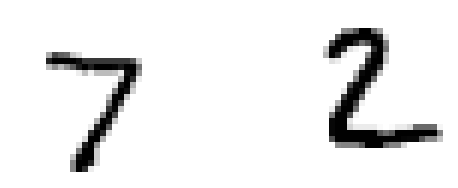

In [20]:
for i, image in enumerate([x_test[0], x_test[1]]):
    plt.subplot(2, 2, i + 1)
    plt.axis('off')
    plt.imshow(image, cmap=plt.cm.gray_r, interpolation='nearest')

Prepare scoring payload with records to score.

In [21]:
score_0 = x_test[0].flatten().tolist()
score_1 = x_test[1].flatten().tolist()

In [22]:
scoring_payload = {"input_data": [{"values": [score_0, score_1]}]}

Use ``client.deployments.score()`` method to run scoring.

In [23]:
predictions = client.deployments.score(deployment_uid, scoring_payload)

In [24]:
print(json.dumps(predictions, indent=2))

{
  "predictions": [
    {
      "id": "dense_2",
      "fields": [
        "prediction",
        "prediction_classes",
        "probability"
      ],
      "values": [
        [
          [
            0.0,
            0.0,
            0.0,
            0.0,
            0.0,
            0.0,
            0.0,
            1.0,
            0.0,
            0.0
          ],
          7,
          [
            0.0,
            0.0,
            0.0,
            0.0,
            0.0,
            0.0,
            0.0,
            1.0,
            0.0,
            0.0
          ]
        ],
        [
          [
            0.0,
            0.0,
            1.0,
            0.0,
            0.0,
            0.0,
            0.0,
            0.0,
            0.0,
            0.0
          ],
          2,
          [
            0.0,
            0.0,
            1.0,
            0.0,
            0.0,
            0.0,
            0.0,
            0.0,
            0.0,
            0.0
          ]


<a id="cleanup"></a>
## 5. Clean up 

If you want to clean up all created assets:
- experiments
- trainings
- pipelines
- model definitions
- models
- functions
- deployments

please follow up this sample [notebook](https://github.com/IBM/watson-machine-learning-samples/blob/master/cpd5.0/notebooks/python_sdk/instance-management/Machine%20Learning%20artifacts%20management.ipynb).

<a id="summary"></a>
## 6. Summary and next steps

You successfully completed this notebook! You learned how to use Keras machine learning library as well as `watsonx.ai` for model creation and deployment.
 
Check out our _<a href="https://ibm.github.io/watsonx-ai-python-sdk/samples.html" target="_blank" rel="noopener no referrer">Online Documentation</a>_ for more samples, tutorials, documentation, how-tos, and blog posts. 

### Authors

**Daniel Ryszka**, Software Engineer

Copyright © 2020-2024 IBM. This notebook and its source code are released under the terms of the MIT License.